Prototypes shape: (14, 50), elements: [-1  1]
Test patterns shape: (25, 50), elements: [-1  1]


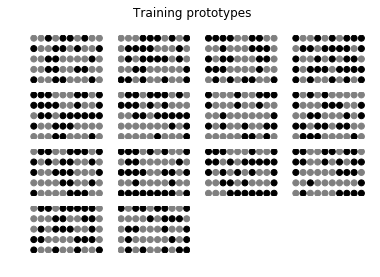

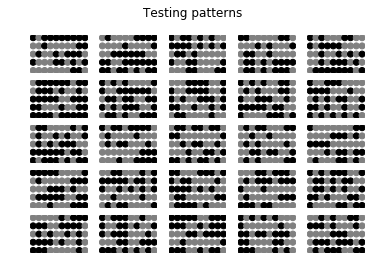

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot

np.random.seed(0)
# training prototyps
prototypes = np.random.choice([-1, +1], [14, 50])
fig, axes = pyplot.subplots(4, 4)
fig.suptitle('Training prototypes')
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    if i >= len(prototypes):
        continue
    colors = ['gray' if prototypes[i, j] == 1 else 'black' for j in range(prototypes.shape[1])]
    ax.scatter(np.repeat(list(range(10)), 5), np.tile(list(range(5)), 10), c=colors)
# testing patterns
vectors = np.random.choice([-1, +1], [25, 50])
fig, axes = pyplot.subplots(5, 5)
fig.suptitle('Testing patterns')
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    if i >= len(vectors):
        continue
    colors = ['gray' if vectors[i, j] == 1 else 'black' for j in range(vectors.shape[1])]
    ax.scatter(np.repeat(list(range(10)), 5), np.tile(list(range(5)), 10), c=colors)

print("Prototypes shape: {}, elements: {}".format(prototypes.shape, np.unique(prototypes)))
print("Test patterns shape: {}, elements: {}".format(vectors.shape, np.unique(vectors)))

Network capacity is roughly .14 times the number of nodes. 7 is exactly the max capacity of the network (.14 * 50 = 7)

### Hopfield network definition

In [5]:
import itertools


class HopfieldNet(object):
    def __init__(self):
        self.units = np.random.choice([-1, +1], 50)
        self.weights = np.zeros([50, 50])
        self.threshold = 0

    def train(self, prototypes):
        n = len(prototypes)
        print("Training with {} prototypes".format(n))
        for i, j in itertools.product(list(range(50)), list(range(50))):
            if i == j:
                self.weights[i, j] = 0  # no self-connections
                continue
            self.weights[i, j] = (1 / n) * sum(
                prototypes[u, i] * prototypes[u, j]
                # (2 * prototypes[u, i] - 1) * (2 * prototypes[u, j] - 1) 
                for u in range(n))

    def set_initial(self, pattern):
        assert len(np.unique(pattern)) == 2, pattern
        for i in range(len(pattern)):
            self.units[i] = pattern[i]
            
    def update(self):
        units = list(range(len(self.units)))
        np.random.shuffle(units)
        changed = False
        for unit in units:
            unit_changed = self.update_unit(unit)
            changed = changed or unit_changed
        return changed

    def update_unit(self, unit):
        prev_state = self.units[unit]
        activation = sum(self.weights[unit, j] * self.units[j]
               for j in range(len(self.units)))
        if activation >= self.threshold:
            self.units[unit] = +1
        else:
            self.units[unit] = -1
        changed = prev_state != self.units[unit]
        return changed


### Run

In [13]:
import copy


def hamming_distance(state1, state2):
    assert len(state1) == len(state2)
    return sum(state1[i] != state2[i] for i in range(len(state1)))


prototype_nums = [1, 4, 7, 14]
num_unique_states, prototype_distances, block_updates = {}, {}, {}
for num_prototypes in prototype_nums:
    # train network
    net = HopfieldNet()
    train_prototypes = prototypes[:num_prototypes, :]
    net.train(train_prototypes)
    # test network and count the number of updates required to converge
    updates, final_states = [], []
    for pattern in range(vectors.shape[0]):
        net.set_initial(vectors[pattern, :])
        for block in itertools.count():
            changed = net.update()
            if not changed:
                break  # done, converged
        final_states.append(copy.deepcopy(net.units))
        updates.append(block)
    block_updates[num_prototypes] = updates

    # compare the final states to themselves and to the prototypes
    num_unique = 0
    unique_states = []
    prototype_distance = []
    for state in final_states:
        # figure out unique states
        overlap = False
        for distinct_state in unique_states:
            distance = hamming_distance(state, distinct_state)
            if distance == 0:
                overlap = True
                break
        if not overlap:
            num_unique += 1
            unique_states.append(state)
        # compare to prototypes
        min_distance = 999
        for prototype in train_prototypes:
            distance = hamming_distance(state, prototype)
            if distance < min_distance:  # closest prototype
                min_distance = distance
        prototype_distance.append(min_distance)
    num_unique_states[num_prototypes] = num_unique
    prototype_distances[num_prototypes] = prototype_distance
print("Updates", block_updates)
print("Unique states", num_unique_states)
print("Prototype distances", prototype_distances)


Training with 1 prototypes
Training with 4 prototypes
Training with 7 prototypes


Training with 14 prototypes


Updates {1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 4: [2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1], 7: [2, 4, 2, 2, 1, 3, 2, 4, 3, 2, 4, 4, 2, 2, 3, 2, 3, 1, 2, 1, 3, 1, 3, 2, 2], 14: [4, 5, 3, 3, 4, 3, 4, 4, 3, 6, 5, 5, 5, 3, 8, 2, 4, 4, 4, 4, 2, 2, 2, 5, 4]}
Unique states {1: 2, 4: 12, 7: 17, 14: 18}
Prototype distances {1: [50, 50, 0, 0, 50, 50, 50, 50, 0, 0, 0, 0, 0, 0, 50, 50, 0, 50, 50, 50, 50, 0, 50, 0, 0], 4: [23, 23, 11, 24, 24, 23, 24, 23, 0, 24, 0, 0, 0, 0, 24, 23, 12, 13, 23, 23, 0, 0, 23, 0, 10], 7: [0, 0, 0, 22, 22, 22, 22, 0, 14, 23, 12, 9, 5, 0, 11, 23, 0, 0, 18, 0, 14, 0, 18, 0, 0], 14: [13, 13, 13, 13, 9, 11, 7, 5, 10, 17, 5, 10, 1, 5, 13, 13, 3, 13, 13, 10, 10, 5, 11, 13, 9]}


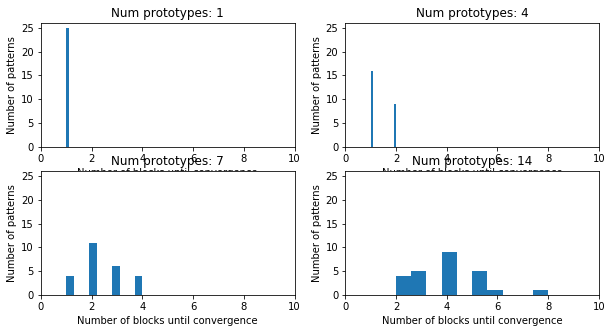

In [14]:
% matplotlib inline
from matplotlib import pyplot

fig, axes = pyplot.subplots(2, 2, figsize=(10, 5))
for ax, (num_prototypes, updates) in zip(axes.flatten(), block_updates.items()):
    ax.set_title('Num prototypes: {}'.format(num_prototypes))
    ax.hist(updates)
    ax.set_xlabel("Number of blocks until convergence")
    ax.set_ylabel("Number of patterns")
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 26])

The more prototypes, the longer it takes for patterns to converge.
Intuitively, this is due to more attractors pulling the states in different directions. As the number of attractors increases, the influence of each single attractor diminishes and spurious states start to occur because of all the different influences.
It's interesting to see that with a single prototype, everything converges after just one round of updates.

### Unique convergence states

Text(0,0.5,'Number of unique states')

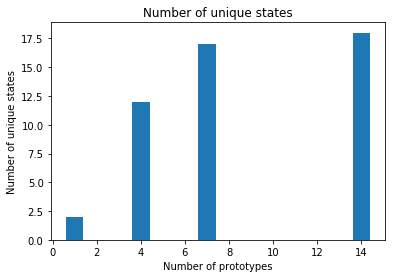

In [15]:
%matplotlib inline
from matplotlib import pyplot

pyplot.figure()
pyplot.title('Number of unique states')
pyplot.bar(list(num_unique_states.keys()), list(num_unique_states.values()))
pyplot.xlabel('Number of prototypes')
pyplot.ylabel('Number of unique states')


With a single prototype, there are only 2 unique states that the network converges to. I.e. the prototype and the inverse of the prototype (all +1 and -1s inversed).
With more prototypes, the number of final states obviously increases, but again by more than just the number of prototypes.
For instance, with four prototypes, there are now 12 final states that the patterns converge to. This is likely not just due to the inverse states mentioned above but also averages between the prototypes.


### Distance to prototypes

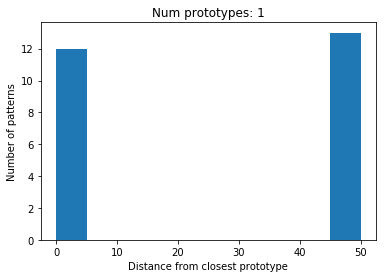

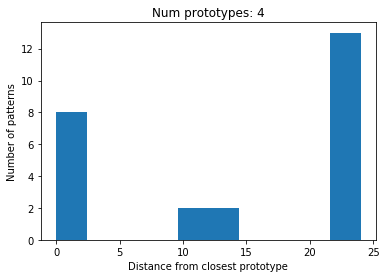

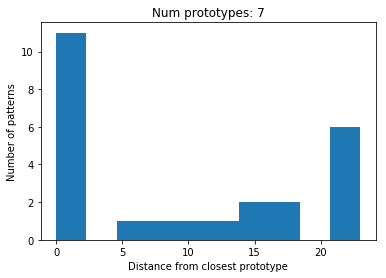

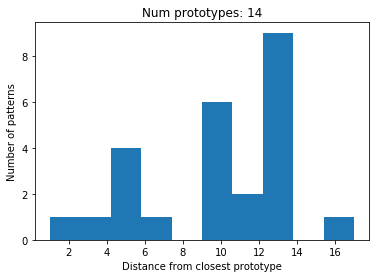

In [16]:
%matplotlib inline
for num_prototypes, distances in prototype_distances.items():
    pyplot.figure()
    pyplot.title('Num prototypes: {}'.format(num_prototypes))
    pyplot.hist(distances)
    pyplot.xlabel("Distance from closest prototype")
    pyplot.ylabel("Number of patterns")

This shows both the strengths and weaknesses of the Hopfield model: for a single prototype, all patterns converge BUT due to the weights being mirrored, they converge to the prototype itself and the inverse prototype (all +1 --> -1 and vice-versa). So the distance is either 0 or 50.

As the number of stored prototypes increases, things get a little easier and spurious states start to occur. The histogram thus becomes more spread out and less patterns converge to the prototypes. With more prototypes, this would become even messier (cf. Tang, Schrimpf, Lotter et al. 2017 ;-)).
More prototypes means that fewer states will converge to their attractors due to spurious states. Network capacity is not large enough.

I wish there was an easy way to resolve this. Hopfield networks and the whole attractor network direction sounds really promising but then there are all these small issues with them that make them unusable. Perhaps with mirror-states, there is by using symmetric weights throughout the whole network. But spurious states are the real killer, maybe using something like random bumps would help resolve this issue.



### Synchronous updates

Training with 7 prototypes


giving up
giving up
giving up


Text(0,0.5,'Number of patterns')

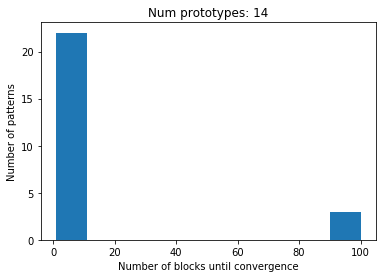

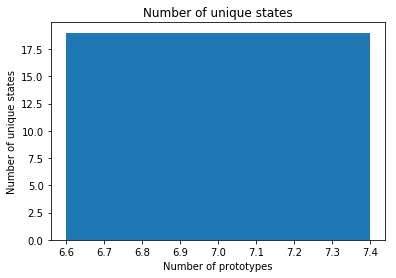

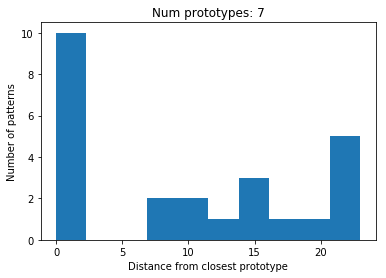

In [22]:
% matplotlib inline
from matplotlib import pyplot
import copy


class SyncHopfieldNet(HopfieldNet):
    def update(self):
        old_state = copy.deepcopy(self.units)
        for unit in range(len(self.units)):
            activation = sum(self.weights[unit, j] * old_state[j]
                             for j in range(len(self.units)))
            if activation >= self.threshold:
                self.units[unit] = +1
            else:
                self.units[unit] = -1
        distance = hamming_distance(old_state, self.units)
        changed = distance > 0
        return changed

    def update_unit(self, unit):
        prev_state = self.units[unit]
        activation = sum(self.weights[unit, j] * self.units[j]
                         for j in range(len(self.units)))
        if activation >= self.threshold:
            self.units[unit] = +1
        else:
            self.units[unit] = -1
        changed = prev_state != self.units[unit]
        return changed


# train network
net = SyncHopfieldNet()
train_prototypes = prototypes[:7, :]
net.train(train_prototypes)
# test network and count the number of updates required to converge
updates, final_states = [], []
for pattern in range(vectors.shape[0]):
    net.set_initial(vectors[pattern, :])
    for block in itertools.count():
        changed = net.update()
        if not changed:
            break  # done, converged
        if block > 99:
            print("giving up")
            break  # give up
    final_states.append(copy.deepcopy(net.units))
    updates.append(block)

# compare the final states to themselves and to the prototypes
num_unique = 0
unique_states = []
prototype_distance = []
for state in final_states:
    # figure out unique states
    overlap = False
    for distinct_state in unique_states:
        distance = hamming_distance(state, distinct_state)
        if distance == 0:
            overlap = True
            break
    if not overlap:
        num_unique += 1
        unique_states.append(state)
    # compare to prototypes
    min_distance = 999
    for prototype in train_prototypes:
        distance = hamming_distance(state, prototype)
        if distance < min_distance:  # closest prototype
            min_distance = distance
    prototype_distance.append(min_distance)

# Time till convergence
pyplot.figure()
pyplot.title('Num prototypes: {}'.format(num_prototypes))
pyplot.hist(updates)
pyplot.xlabel("Number of blocks until convergence")
pyplot.ylabel("Number of patterns")

# Unique states
pyplot.figure()
pyplot.title('Number of unique states')
pyplot.bar([7], [num_unique])
pyplot.xlabel('Number of prototypes')
pyplot.ylabel('Number of unique states')

# Distance to prototypes
pyplot.figure()
pyplot.title('Num prototypes: {}'.format(7))
pyplot.hist(prototype_distance)
pyplot.xlabel("Distance from closest prototype")
pyplot.ylabel("Number of patterns")


With synchronous updating, network behavior in terms of final states and distance to prototypes for many patterns is the same.

However, the story is quite different in terms of block updats:
the network converges okay for many of the patterns but
for three of the patterns, the network never converges.

Looks like the stochastic approach of asynchronous updating is more stable.
When updates are done synchronously, this stability fades and the network fails to converge for some of the patterns, 
bouncing around between states and never landing in an energy minima.